<a href="https://colab.research.google.com/github/fabriciocovalesci/tcc_predict_crypto/blob/main/model_predict/predict_crypto/dai/Dai_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modelo preditivo Dai

- Instalar biblioteca **yfinance**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 6.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


- Importar bibliotecas de manipulação de dados

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

- Importar bibliotecas realizar as predições

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

- Importar bibliotecas para plotar gráficos

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

- Importar bibliotecas internas do python

In [ ]:
from functools import reduce
from datetime import datetime

- Definir datas para capturar os dados

In [ ]:
date_today = datetime.strftime(datetime.today(), '%Y-%m-%d')
date_init = "2014-01-01"

- Criar funções auxiliares 

In [ ]:
TICKER = "DAI-USD"

def download_tickers(ticker):
  try:
    asset = yf.download(ticker, start=date_init, end=date_today, interval='1d')
    return asset.Close
  except Exception as err:
    print(f"ERROR: {err}")

  
def create_data_frame(asset_close, ticker):
  return pd.DataFrame(asset_close).rename(columns = {'Close': ticker})


def mean_absolute_percentage_error(y_true, y_pred):
	"""Take in true and predicted values and calculate the MAPE score"""
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Download dos dados

In [ ]:
df_dai = yf.download(TICKER, date_init, date_today)
df_dai = df_dai.reset_index()

[*********************100%***********************]  1 of 1 completed


- Renomear colunas

In [ ]:
df_dai.rename({'Date': 'timestamp', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Adj Close': 'close', 'Volume': 'volume' }, axis=1, inplace=True)

In [ ]:
df_dai.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
Close               float64
close               float64
volume                int64
dtype: object

- Converter data

In [ ]:
df_dai['timestamp'] = pd.to_datetime(df_dai['timestamp'], format="%Y-%m-%d")

- Criar médias móveis de 7 dias e 21 dias

In [ ]:
df_dai['mm7d'] = df_dai['close'].rolling(7).mean()
df_dai['mm21d'] = df_dai['close'].rolling(21).mean()

df_dai.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1067,2022-10-24,1.000359,1.000831,0.998587,0.999743,0.999743,268269167,0.999898,0.999745
1068,2022-10-25,0.999705,1.001919,0.998374,0.999954,0.999954,346286705,0.999938,0.999749
1069,2022-10-26,0.999809,1.001029,0.998938,0.999775,0.999775,356099703,0.999890,0.999754
1070,2022-10-27,0.999735,1.000848,0.998507,0.999720,0.999720,338567790,0.999886,0.999764
1071,2022-10-28,0.999722,1.000945,0.998736,1.000306,1.000306,390558637,0.999942,0.999797


- Função de agrupamento dos dados

In [ ]:
def group_data(type_group):
  new_df = df_dai.groupby(pd.Grouper(key="timestamp", freq=type_group)).sum()
  new_df.reset_index(inplace=True)
  return new_df

- Função para plotar grafico conforme o Agrupamento dos Dados
- Tipo de agrupamento:
- Por Meses (M) ou por Semanas (W)
- Por Ano (year)
- Tipo de grafico: 'bar',  'line',  'hist',  'barh'

In [ ]:
def create_plot_custom(filter_Mounth_or_Week, year, type_plot):
  """ 
    Cria um grafico filtrando por Ano, Meses ou Semanas

    filter_Mounth_or_Week: 'M' ou 'W'
    type_plot: 'line', 'bar', 'hist', 'barh'
  
  """
  if year >= 2014 and year <= 2022 and filter_Mounth_or_Week in ("M", "W"):
    filtro_label = None
    df_filter = group_data(filter_Mounth_or_Week)
    include = df_filter[df_filter['timestamp'].dt.year == year]
    meses = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    if len(include.index) <= 12:
      include.index = meses[:len(include.index)]
      filtro_label = "Meses"
    elif len(include.index) > 50:
      include.index = [i for i in range(0, len(include.index))]
      filtro_label = "Semanas"
    include.plot(y="close", kind=type_plot, figsize=(14, 8),rot=30, title=f'Distruibuição por {filtro_label} - ano {year}', ylabel='Preço US$', xlabel=filtro_label, color="blue")

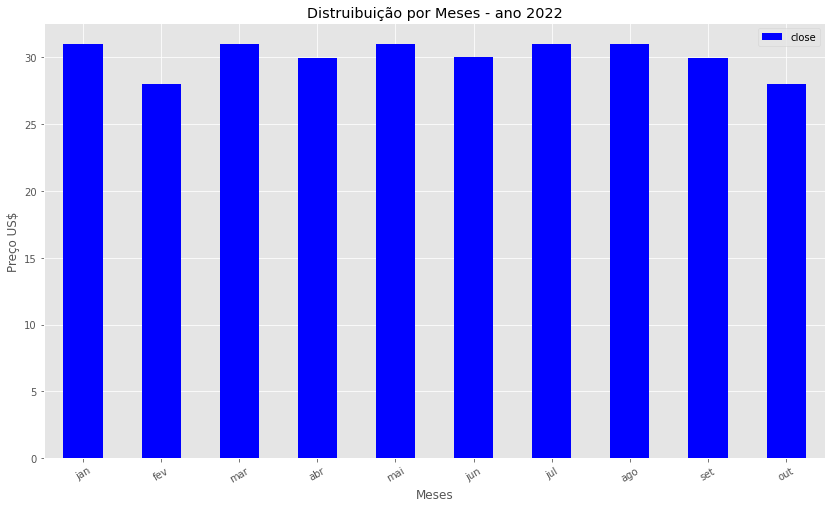

In [ ]:
create_plot_custom("M", 2022, "bar")

- Empurrando para frente os valores da criptomoeda

In [ ]:
df_dai['close'] = df_dai['close'].shift(-1)
df_dai.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1067,2022-10-24,1.000359,1.000831,0.998587,0.999743,0.999954,268269167,0.999898,0.999745
1068,2022-10-25,0.999705,1.001919,0.998374,0.999954,0.999775,346286705,0.999938,0.999749
1069,2022-10-26,0.999809,1.001029,0.998938,0.999775,0.999720,356099703,0.999890,0.999754
1070,2022-10-27,0.999735,1.000848,0.998507,0.999720,1.000306,338567790,0.999886,0.999764
1071,2022-10-28,0.999722,1.000945,0.998736,1.000306,NaN,390558637,0.999942,0.999797


- Remover os dados nulos

In [ ]:
df_dai.dropna(inplace=True)
df_dai

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
20,2019-12-12,1.003136,1.010460,0.996499,1.005456,1.003854,2372303,1.004303,1.003890
21,2019-12-13,1.005864,1.007776,0.999520,1.003854,1.007594,2211492,1.004582,1.004426
22,2019-12-14,1.003283,1.009757,1.001476,1.007594,1.003221,1645619,1.004840,1.004012
23,2019-12-15,1.007594,1.010131,0.981594,1.003221,1.006222,1505775,1.004777,1.004057
24,2019-12-16,1.003221,1.022722,0.999106,1.006222,1.000816,3403102,1.004747,1.004019
...,...,...,...,...,...,...,...,...,...
1066,2022-10-23,0.999931,1.001060,0.998971,1.000171,0.999743,169650072,0.999872,0.999761
1067,2022-10-24,1.000359,1.000831,0.998587,0.999743,0.999954,268269167,0.999898,0.999745
1068,2022-10-25,0.999705,1.001919,0.998374,0.999954,0.999775,346286705,0.999938,0.999749
1069,2022-10-26,0.999809,1.001029,0.998938,0.999775,0.999720,356099703,0.999890,0.999754


- Testar se o DataFrame possui dados nulos

In [ ]:
assert df_dai.isnull().sum().sum() == 0

- Separar os dados em Treino, Teste e Validação. 

In [ ]:
qtd_linhas = len(df_dai)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:736 linhas teste= 736:1050 linhas validação= 1050'

- Separar a **labels** que será o target a ser encontrado pelo modelo preditivo
- Separar as **features** que serão utilizadas para prever o valor final

In [ ]:
features = df_dai.drop(['timestamp', 'close'], 1)
labels = df_dai['close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


- Escolhendo as melhores features com Kbest

In [ ]:
features_list = ('timestamp', 'open', 'high', 'low', 'volume', 'mm7d', 'mm21d')

selector = SelectKBest(score_func=f_regression, k='all').fit(features, labels)
x_new = selector.transform(features)
scores = selector.scores_

raw_pairs = zip(features_list[1:], scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print("Melhores features:")
print(k_best_features_final)

Melhores features:
{'mm21d': 585.8700118407396, 'volume': 379.68092509323753, 'open': 278.636240563466, 'mm7d': 88.02952278306135, 'low': 70.44811909712664, 'high': 5.115653863927321}


- Separando as features escolhidas, com melhor pontuação

In [ ]:
features = df_dai.loc[:,['mm7d','volume', 'open']]
features

,mm7d,volume,open
20,1.004303,2372303,1.003136
21,1.004582,2211492,1.005864
22,1.004840,1645619,1.003283
23,1.004777,1505775,1.007594
24,1.004747,3403102,1.003221
...,...,...,...
1066,0.999872,169650072,0.999931
1067,0.999898,268269167,1.000359
1068,0.999938,346286705,0.999705
1069,0.999890,356099703,0.999809


- Criando Pipeline

In [ ]:
pipeline_linear_regression = make_pipeline(MinMaxScaler(), LinearRegression())

- Separa os dados de treino teste e validação

In [ ]:
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

736 736
314 314


- Treina modelo

In [ ]:
pipeline_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

- Confere 

In [ ]:
score_model = pipeline_linear_regression.score(X_test, y_test)
f'Teste pontuação para avaliar a consistência do modelo: {score_model * 100:.2f}%'

'Teste pontuação para avaliar a consistência do modelo: -193.16%'

- Pega último dado do dataframe

In [ ]:
data_pred = ['mm7d','volume', 'open']
df_dai.tail(1)

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1070,2022-10-27,0.999735,1.000848,0.998507,0.99972,1.000306,338567790,0.999886,0.999764


- Testar a predição

In [ ]:
pipeline_linear_regression.predict(df_dai.tail(1)[data_pred])

array([1.00078456])

- Realizar a predição com os dados de testes(dados que o modelo desconhece)

In [ ]:
previsao = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

data_btc_full=df_dai["timestamp"]
data_btc = data_btc_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

res_full = df_dai["close"]
res = res_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]


predict2 = pipeline_linear_regression.predict(previsao)


df = pd.DataFrame({ "data_dai": data_btc, "real": res , "previsao": predict2 })

df["real"] = df["real"].shift(+1)

df.set_index("data_dai", inplace= True)

df.tail()



,real,previsao
data_dai,,
2022-10-22,0.999924,1.001017
2022-10-23,1.000171,1.001119
2022-10-24,0.999743,1.000960
2022-10-25,0.999954,1.000805
2022-10-26,0.999775,1.000756


- Plotar os resultados

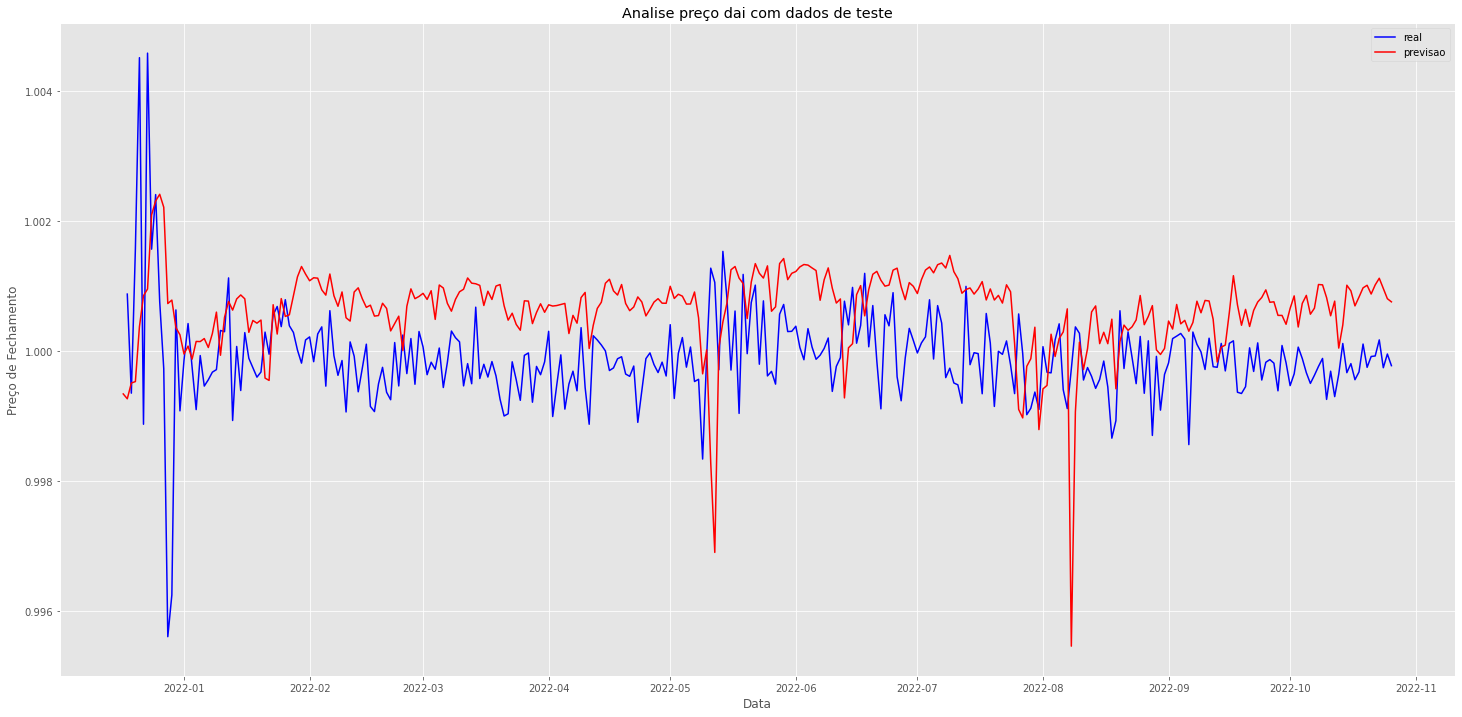

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Analise preço dai com dados de teste")
plt.plot(df["real"], label="real", color="blue")
plt.plot(df["previsao"], label="previsao", color="red")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
leg = plt.legend()

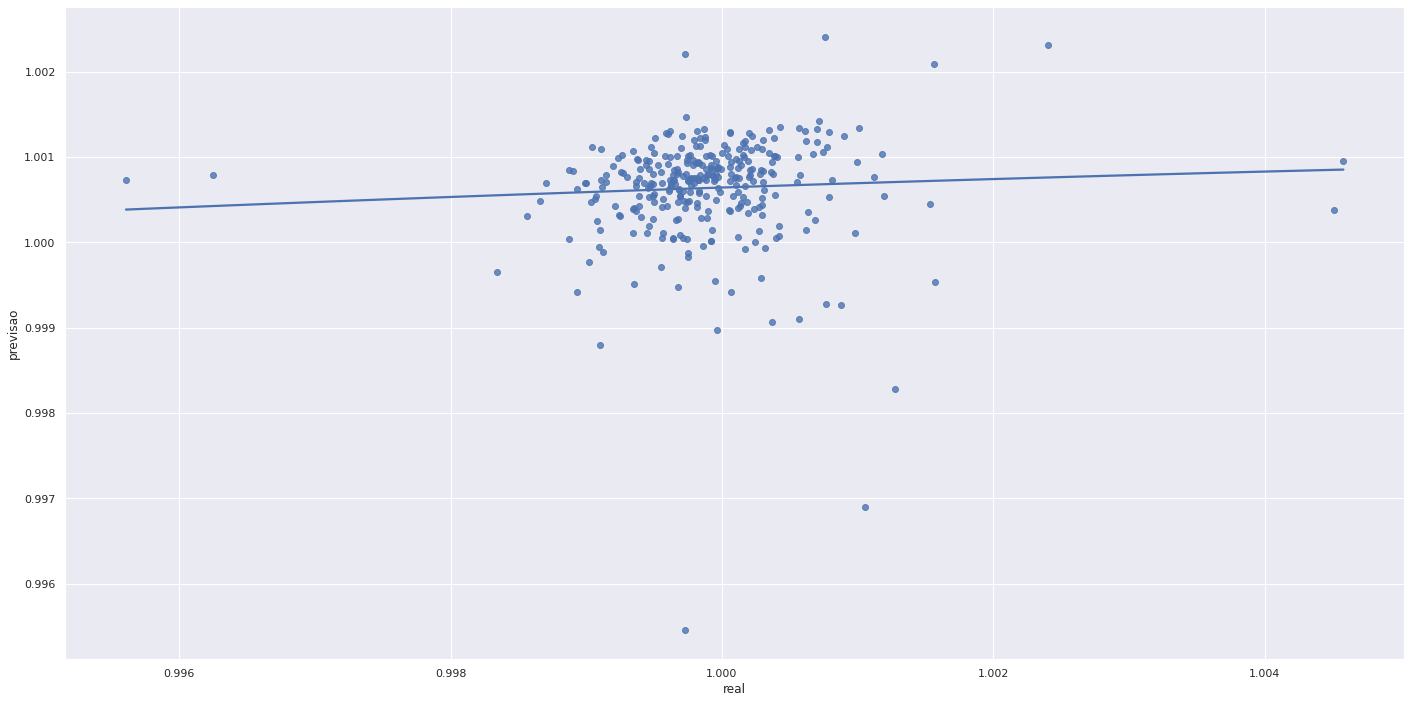

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(24, 12)})
sns.regplot(x ="real", y ="previsao", data = df, ci=False, order=2)

- Export modelo preditivo 

In [ ]:
joblib.dump(pipeline_linear_regression, 'model_dai_usd.pkl')

['model_dai_usd.pkl']

- Import modelo preditivo

In [ ]:
model = joblib.load('model_dai_usd.pkl')

In [ ]:
model

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])